In [22]:
from radd.tools.colors import get_cpals, style_params
sp = style_params()
sns.set(font='Helvetica')
sns.set(style='ticks',rc={'text.color': 'black', 'axes.labelcolor': 'black', 'figure.facecolor': 'white'})

"""
COLORS LISTS
"""
colors=sp['colors'];

In [34]:
import random
from numpy.random import sample as rs
from numpy import hstack as hs
from numpy import newaxis as na
from radd import theta
from scipy.stats import ttest_rel as ttrel
from matplotlib import animation
from scipy.stats.distributions import norm, uniform
from scipy.misc import factorial
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import seaborn as sns
from copy import deepcopy
from JSAnimation import IPython_display, HTMLWriter
from matplotlib import animation
from IPython.display import HTML
flatui=[colors[4], colors[3], colors[-7]]
c=[flatui[0], flatui[0], flatui[1], flatui[1], flatui[2], flatui[2]]

In [24]:
dt=.001
si=.01
tb=.8
ntot=1000
dx=np.sqrt(si*dt)

prior = uniform.rvs(0,1,1000)

In [25]:
temporal_dynamics = lambda p, t: np.cosh(p['xb'][:,na]*t)
resp_up = lambda trace, a: np.argmax((trace.T>=a).T, axis=2)*dt
ss_resp_up = lambda trace, a: np.argmax((trace.T>=a).T, axis=3)*dt
resp_lo = lambda trace: np.argmax((trace.T<=0).T, axis=3)*dt
RT = lambda ontime, rbool: ontime[:,na]+(rbool*np.where(rbool==0, np.nan, 1))
RTQ = lambda zpd: map((lambda x:mq(x[0][x[0]<x[1]], prob)), zpd)
prop = lambda n, k: factorial(n)/(factorial(k)*factorial(n-k))
likelihood = lambda fact, prior, n, k: (fact*prior**k)*(1-prior)**(n-k)

In [26]:
p = theta.get_default_inits(kind='pro', depends_on={'v':'pGo'})

In [27]:
def vectorize_params(p, pc_map, ncond=1):
    pvc = ['a', 'tr', 'xb']
    for pkey in pvc:
        p[pkey]=p[pkey]*np.ones(ncond)
    for pkey, pkc in pc_map.items():
        if ncond==1:
            p[pkey]=np.asarray([p[pkey]])
            break
        elif pkc[0] not in p.keys():
            p[pkey] = p[pkey]*np.ones(len(pkc))
        else:
            p[pkey] = array([p[pc] for pc in pkc])
        return p

def update_execution(p):
    """ update Pg (probability of DVg +dx) and Tg (num go process timepoints)
    for go process and get get dynamic bias signal if 'x' model
    """
    #Pex = 0.5*(1 + (p['vd']/p['vi'])*dx/si)
    Pd = 0.5*(1 + p['vd']*dx/si)
    Pi = 0.5*(1 + p['vi']*dx/si)
    Tex = np.ceil((tb-p['tr'])/dt).astype(int)

    return Pd, Pi, Tex

In [28]:
### nc=2
lr=.02
nssd=5
dt=.001
si=.1
ntot=200
tb=1.5

state = np.where(rs(ntot)>.5, 'l', 'r')
dx=np.sqrt(si*dt)

In [40]:
si=3.5; dt=.001; tau=.05; tmax=1.5; rmax=70; b=35; g=15; ntrials=10
timepoints = np.arange(0, tmax, dt)
ntp=len(timepoints)
Id=4.5
Ii=3.
Z=20
k=.75
wdi=.2
wid=.22
Io=5

NInput = lambda x, r: rmax/(1+np.exp(-(x-b)/g))-r
dspace = lambda rd, ri: (rd-ri)/np.sqrt(2)

rd = np.zeros(ntp)
ri = np.zeros(ntp)
dv = np.zeros(ntp)

Ed=si*np.sqrt(dt/tau)*rs(ntp)
Ei=si*np.sqrt(dt/tau)*rs(ntp)

rd[0]=.01
ri[0]=.01

In [41]:
def decision_network(Id=6, Ii=3, Io=2, wdi=.22, wid=.22, k=.85, si=2.3, dt=.001, tau=.005, tmax=1.5, rmax=70, b=35, g=15, ntrials=10, y=1, Z=20, IoMax=4.5):
      
    timepoints = np.arange(0, tmax, dt)
    ntp=len(timepoints)

    rd = np.zeros(ntp)
    ri = np.zeros(ntp)
    dv = np.zeros(ntp)

    NInput = lambda x, r: rmax/(1+np.exp(-(x-b)/g))-r
    dspace = lambda rd, ri: (rd-ri)/np.sqrt(2)

    Ed=si*np.sqrt(dt/tau)*rs(ntp)
    Ei=si*np.sqrt(dt/tau)*rs(ntp)
    x=100
    rd[:x], ri[:x] = [v[0][:x]+Io+v[1][:x] for v in [[rd,Ed],[ri,Ei]]]

    subZ=True
    IIi, IId = [deepcopy(ii) for ii in [Id, Ii]]
    for i in xrange(x, ntp):

        rd[i] = rd[i-1]+dt/tau*(NInput(Id + y*Io + k*rd[i-1] + -wid*ri[i-1], rd[i-1])) + Ed[i]
        ri[i] = ri[i-1]+dt/tau*(NInput(Ii + y*Io + k*ri[i-1] + -wdi*rd[i-1], ri[i-1])) + Ei[i]

        if dv[i-1]<Z and subZ:
            dv[i] = dspace(rd[i-1], ri[i-1])
        elif subZ:
            Id,Ii,Io = -Id*Io, -Ii*Io, Io
            wdi, wid=0, 0
            NInput = lambda x, r: Io/(1+np.exp(-(x-b)/g))-r-IoMax
            subZ=False
        elif not subZ and rd[i]<(IoMax+1):
            x = len(rd[i:])
            rd0=hs(rd[:200].tolist()*3)
            ri0=hs(ri[:200].tolist()*3)
            rd, ri=hs([rd[:i], rd0]), hs([ri[:i], ri0])
            break

    return rd, ri, dv[:dv[dv<Z].argmax()]


In [42]:
def basic_network(Id=6, Ii=3, Io=2, wdi=.22, wid=.22, k=.85, si=2.3, dt=.01, tau=.005, tmax=1.5, rmax=70, b=35, g=15, ntrials=10, y=1, Z=20, IoMax=4.5, wd=1., wi=1., onmax=800):
      
    timepoints = np.arange(0, tmax, dt)
    ntp=len(timepoints)

    rd = np.zeros(ntp)
    ri = np.zeros(ntp)
    dv = np.zeros(ntp)
    dx=np.sqrt(si*dt)

    NInput = lambda x, r: rmax/(1+np.exp(-(x-b)/g))-r
    dspace = lambda rd, ri: (rd-ri)/np.sqrt(2)

    Ed=si*np.sqrt(dt/tau)*rs(ntp)
    Ei=si*np.sqrt(dt/tau)*rs(ntp)
    x=100
    rd[:x], ri[:x] = [v[0][:x]+Io+v[1][:x] for v in [[rd,Ed],[ri,Ei]]]

    subZ=True
    IIi, IId = [deepcopy(ii) for ii in [Id, Ii]]
    for i in xrange(x, ntp):

        rd[i] = rd[i-1]+dt/tau*(NInput(wd*Id + y*Io + k*rd[i-1] + -wid*ri[i-1], rd[i-1])) + Ed[i]
        ri[i] = ri[i-1]+dt/tau*(NInput(wi*Ii + y*Io + k*ri[i-1] + -wdi*rd[i-1], ri[i-1])) + Ei[i]

        if dv[i-1]<Z and subZ:
            dv[i] = dspace(rd[i-1], ri[i-1])

        elif dv[i-1]>=Z:
            subZ=False
        if subZ==False:  
            Id=Id-dx; Ii=Ii-dx
        if rd[i]<=rd[0] or i>(x+onmax):
            break
    
    return rd[:i], ri[:i], dv[:dv[dv<=Z].argmax()]

In [43]:
def multi_network(Id=3, Ii=3, Io=2, Ih=3, wdi=.22, wid=.22, walt=.22, k=.85, si=2.3, dt=.01, tau=.05, tmax=1.5, rmax=60, b=3, g=15, ntrials=10, y=1, Z=20, IoMax=4.5, nalt=4, STN=True, pre=50, onmax=800):

    dx=np.sqrt(si*dt)

    rd = np.zeros((nalt, ntp))
    ri = np.zeros((nalt, ntp))
    rh = np.zeros(ntp)
    dv = np.zeros((nalt, ntp))
    output = np.zeros((nalt, ntp))

    dx=np.sqrt(si*dt)

    NInput = lambda x, r: rmax/(1+np.exp(-(x-b)/g))-r
    dspace = lambda rd, ri: (rd-ri)/np.sqrt(2)

    if STN:
        Eh=si*np.sqrt(dt/tau)*rs(ntp)
        rh[:pre] = rh[:pre]+Ih+Eh[:pre]
        long_indirect = lambda r, i: walt*np.sum(r[:, i-1])
        STN_decay= lambda H: H-dx
    else:
        Ih=0
        Eh=np.zeros(ntp)
        long_indirect = lambda r, i: 0
        STN_decay= lambda H: 0

    Ed=si*np.sqrt(dt/tau)*rs((nalt, ntp))
    Ei=si*np.sqrt(dt/tau)*rs((nalt, ntp))
    Eout=si*np.sqrt(dt/tau)*rs((nalt, ntp))

    node_pairs = [[rd,Ed],[ri,Ei]]
    for n in xrange(nalt):
        rd[n,:pre], ri[n,:pre] = [nd[0][n,:pre]+Io[n]+nd[1][n,:pre] for nd in node_pairs]
    output[:pre] = output[:pre]+Eout[:pre]

    subZ=True
    IIi, IId = [deepcopy(ii) for ii in [Id, Ii]]

    for i in xrange(pre, ntp):
        for n in xrange(nalt):
            output[n,i]=output[n, i-1] + dt/tau*(NInput(rd[n, i-1]-rh[i-1]-ri[n, i-1], output[n,i-1]))+ Eout[n, i-1]
            rd[n, i] = rd[n, i-1]+dt/tau*(NInput(Id[n] + y*Io[n] + k*rd[n, i-1] + -wid*ri[n, i-1], rd[n, i-1])) + Ed[n, i-1]
            ri[n, i] = ri[n, i-1]+dt/tau*(NInput(Ii[n] + y*Io[n] + k*ri[n, i-1] + -wdi*rd[n, i-1], ri[n, i-1])) + Ei[n, i-1]
            if dv[n, i-1]<Z and subZ:
                dv[n, i] = dspace(rd[n, i-1], ri[n, i-1])
            elif dv[n, i-1]>=Z:
                subZ=False
            if subZ==False:  
                Id=Id-dx; Ii=Ii-dx
            if rd[n, i]<=rd[n, 0] or i>(pre+onmax):
                break
            if STN:
                ri_all = long_indirect(ri, i)
                rh[i] = rh[i-1]+dt/tau*(NInput(Ih + rh[i-1] + ri_all, rh[i-1])) + Eh[i-1]
                Ih=STN_decay(Ih)

    return rd, ri, rh, output, array([dv[n, :dv[n][dv[n]<=Z].argmax()] for n in xrange(nalt)])

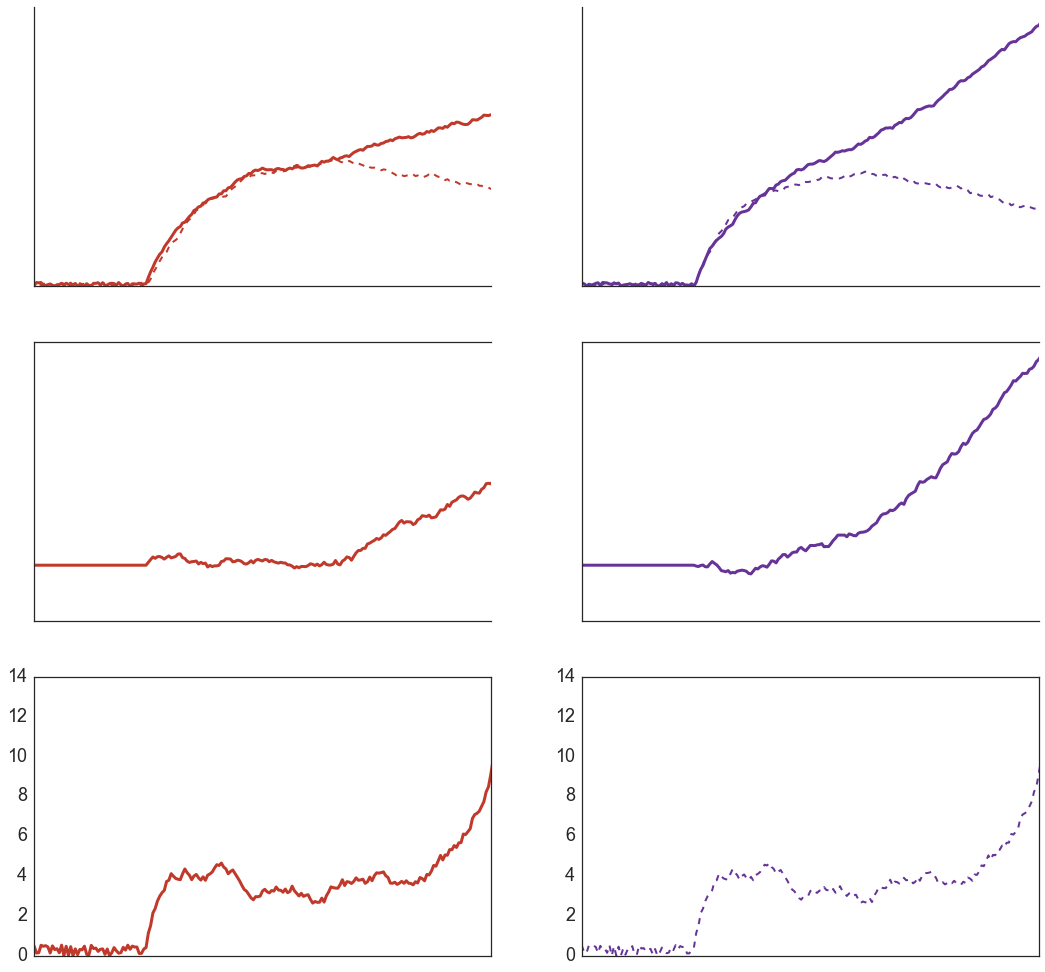

In [52]:
sns.set(font_scale=1.8, style='white')
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(18,17), sharex=True)


rd, ri, rh, output, dv = multi_network(Id=[3.,2.2], Ii=[2.0,2.0], Ih=2., Io=[0, 0], rmax=45, b=22.5, g=11, wid=.28, walt=.4, wdi=.28, Z=20, si=1.9, k=1., tau=.06, dt=.005, nalt=2, STN=True, pre=100)



ax2.plot(rd[0][:len(dv[0])], color=colors[10], linewidth=3)
ax2.plot(ri[0][:len(dv[0])], color=colors[10], linestyle='--', linewidth=2)
ax1.plot(rd[-1][:len(dv[0])], color=colors[-5], linewidth=3)
ax1.plot(ri[-1][:len(dv[0])], color=colors[-5], linestyle='--', linewidth=2)
ax4.plot(dv[0], color=colors[10], linewidth=3)
ax3.plot(dv[-1], color=colors[-5], linewidth=3)
ax2.fill_between(np.arange(100), y1=rd[0,0], color="#7284A0", alpha=.2)

ax5.plot(output[0][:len(dv[0])], color=colors[-5], linewidth=3)
ax6.plot(output[0][:len(dv[0])], color=colors[10], linestyle='--', linewidth=2)


for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlim(50,250)

sns.despine(ax=ax1)
sns.despine(ax=ax2)
ax1.set_ylim(ax2.get_ylim()[0], ax2.get_ylim()[1])


ax3.set_ylim(-5,20)
ax4.set_ylim(-5,20)

sns.despine(top=False, left=False, bottom=False, right=True, ax=ax3)
sns.despine(top=False, left=False, bottom=False, right=True, ax=ax4)

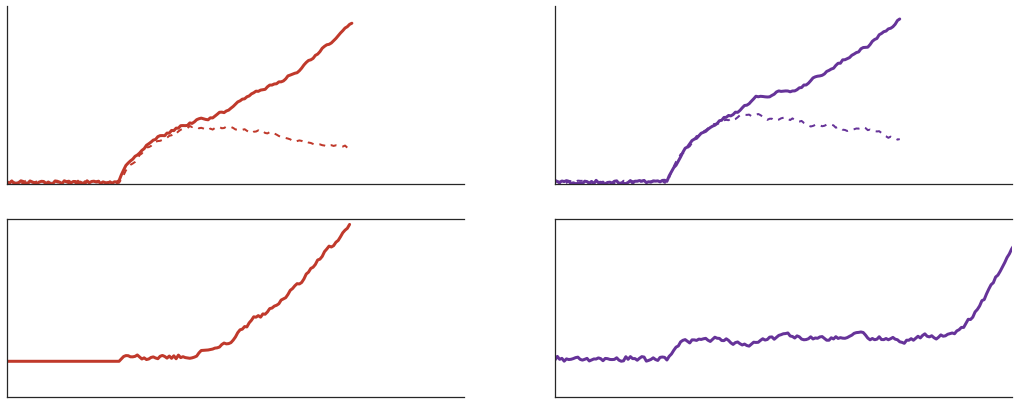

In [54]:
sns.set(font_scale=1.8, style='white')
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18,7), sharex=True)
#f.subplots_adjust(wspace=.4)

rd, ri, rh, output, dv = multi_network(Id=[2.3,2.2], Ii=[2.0,2.0], Ih=3.8, Io=[0, 0], rmax=45, b=22.5, g=10, wid=.24, walt=1, wdi=.28, Z=20, si=2., k=1., tau=.04, dt=.005, nalt=2, STN=True, pre=100)



ax2.plot(rd[0][:len(dv[0])], color=colors[10], linewidth=3)
ax2.plot(ri[0][:len(dv[0])], color=colors[10], linestyle='--', linewidth=2)
ax1.plot(rd[-1][:len(dv[0])], color=colors[-5], linewidth=3)
ax1.plot(ri[-1][:len(dv[0])], color=colors[-5], linestyle='--', linewidth=2)
ax4.plot(output[0], color=colors[10], linewidth=3)
ax3.plot(dv[-1], color=colors[-5], linewidth=3)
ax1.fill_between(np.arange(100), y1=rd[-1,0], color="#7284A0", alpha=.2)

for ax in [ax1, ax2, ax3, ax4]:
      ax.set_xticklabels([])
      ax.set_yticklabels([])
      ax.set_xlim(50,250)

sns.despine(ax=ax1)
sns.despine(ax=ax2)
#ax2.set_ylim(np.min(ax1.get_ylim()[0], ax2.get_ylim()[0]), np.max(ax1.get_ylim()[1], ax2.get_ylim()[1]))


ax3.set_ylim(-5,20)
ax4.set_ylim(-5,20)

sns.despine(top=False, left=False, bottom=False, right=True, ax=ax3)
sns.despine(top=False, left=False, bottom=False, right=True, ax=ax4)

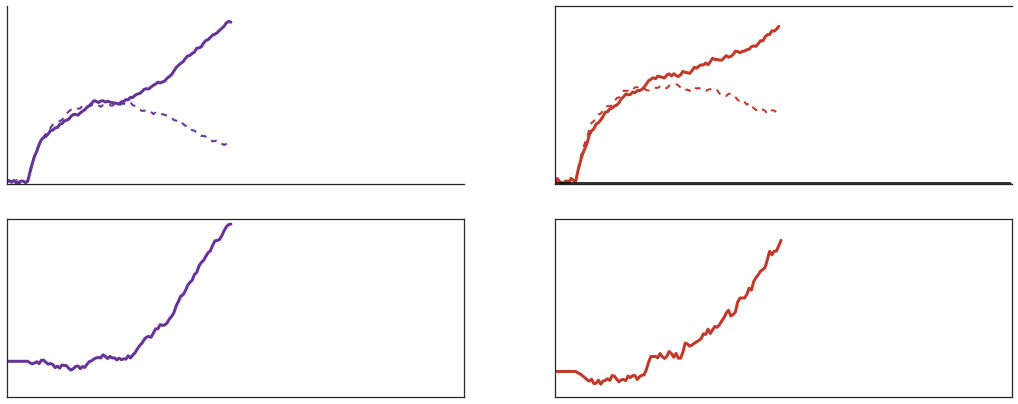

In [72]:
sns.set(font_scale=1.8, style='white')
#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5), sharex=True)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18,7), sharex=True)

rd, ri, rh, output, dv = multi_network(Id=[2.6,2.2], Ii=[2.0,2.0], Ih=0., Io=[0, 0], rmax=45, b=22.5, g=11, wid=.22, walt=0, wdi=.22, Z=20, si=1.9, k=1., tau=.02, dt=.005, nalt=2, STN=False, pre=10)



ax1.plot(rd[0][:len(dv[0])], color=colors[10], linewidth=3)
ax1.plot(ri[0][:len(dv[0])], color=colors[10], linestyle='--', linewidth=2)
ax2.plot(rd[-1][:len(dv[0])], color=colors[-5], linewidth=3)
ax2.plot(ri[-1][:len(dv[0])], color=colors[-5], linestyle='--', linewidth=2)
ax3.plot(dv[0], color=colors[10], linewidth=3)
ax4.plot(dv[-1], color=colors[-5], linewidth=3)
#ax2.plot(np.zeros(200), color='k', alpha=.8, linewidth=5)
#ax2.plot(np.ones(200)*20, color='k', alpha=.8, linewidth=5)
ax2.plot(np.ones(200)*ax2.get_ylim()[0], color='k', alpha=.8, linewidth=5)
ax2.set_xticklabels([])
ax1.set_xticklabels([])
ax2.set_yticklabels([])
ax1.set_yticklabels([])
ax3.set_xticklabels([])
ax4.set_xticklabels([])
ax3.set_yticklabels([])
ax4.set_yticklabels([])
sns.despine(ax=ax1)
sns.despine(top=False, left=False, bottom=False, right=True, ax=ax2)

In [106]:
f.savefig('bsac_perceptual_decision_INVALID.png', dpi=600)

In [14]:
from matplotlib import cm  #Color maps
from matplotlib import pyplot as plt  #The MATLAB-like interface to matplotlib
from mpl_toolkits.mplot3d import Axes3D #Need this for a '3d' projection
import numpy as np #NumPy is used for working with vectors

In [640]:
c=sns.blend_palette([colors[-3], colors[-5], colors[10]], n_colors=1000, input='rgb')


In [702]:
cm1=mpl.colors.ListedColormap(C/255, name='cm1')

In [809]:
cdict = {'red':   [(0.0, 1.0, 1.0),  # red decreases
                   (1.0, 0.0, 0.0)],

         'green': [(0.0, 0.0, 0.0),  # green increases
                   (1.0, 1.0, 1.0)],

         'blue':  [(0.0, 0.0, 0.0),  # no blue at all
                   (1.0, 0.0, 0.0)]}

red_green_cm = mpl.colors.LinearSegmentedColormap('RedGreen', cdict, 100)

In [818]:
import brewer2mpl
red_purple = brewer2mpl.get_map('RdPu', 'Sequential', 9).mpl_colormap
#green_purple = brewer2mpl.get_map('RdGn', 'Sequential', 11).mpl_colormap
red_purple.set_gamma(.2)

In [822]:
wntr = cm.winter_r

In [76]:
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
sns.set(style='white')

# the function that I'm going to plot
def z1_func(x,y):
      return (x**2+y**2)/2
def z2_func(x,y):
      return np.exp(1-(x**2+y**2))
 
x = arange(-3.4,3.4,0.1)
y = arange(-3.4,3.4,0.1)

c=sns.blend_palette([colors[-3], colors[-5], colors[10]], n_colors=1000, input='rgb')

X, Y = meshgrid(x, y) # grid of point
Z1 = z1_func(X,Y) # evaluation of the function on the grid
Z2 = z2_func(X+1.8, Y)
Z3 = z2_func(X-1.8, Y)
fig = plt.figure(figsize=(18,14))
ax = fig.gca(projection='3d')
#surf = ax.plot_surface(X, Y, Z1, rstride=1, cstride=1, 
#                      cmap=cm.Reds, linewidth=0)
#surf2 = ax.plot_surface(X, Y, 26, vmin=20, vmax=39, rstride=3, cstride=3,
#                      cmap=cm.bone, linewidth=.1, alpha=.5)
surf2 = ax.plot_surface(X, Y, (-Z2*4)+23, vmin=1, vmax=35, rstride=3, cstride=3,
                      cmap=cm.BuGn_r, linewidth=.01, alpha=1)
surf2 = ax.plot_surface(X, Y, (-Z3*2)+23, vmin=1, vmax=35, rstride=3, cstride=3,
                      cmap=cm.BuGn_r, linewidth=.01, alpha=1)
surf2 = ax.plot_surface(X, Y, -Z1/1.6+9, vmin=0, vmax=20, rstride=3, cstride=3,
                      cmap=cm.Blues_r, linewidth=.1, alpha=1)
#surf2 = ax.plot_surface(X, Y, 3.5, vmin=0, vmax=20, rstride=3, cstride=3,
#                      cmap=cm.bone_r, linewidth=.1, alpha=1)
surf2 = ax.plot_surface(X, Y, -Z1/1.6-(Z3*2)-(Z2*4), rstride=3, cstride=3, 
                      cmap=cm.GnBu, vmin=-20, vmax=0, linewidth=.01, alpha=1)

#ax.set_zlim(-20,10)
ax.axis("off")
ax.view_init(elev=0, azim=90)

#plt.savefig('attractor_basin_threshold3.png', dpi=600, transparent=True)

In [103]:
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
sns.set(style='white')

# the function that I'm going to plot
def z1_func(x,y):
      return (x**2+y**2)/2
def z2_func(x,y):
      return np.exp(1-(x**2+y**2))
 
x = arange(-3.4,3.4,0.1)
y = arange(-3.4,3.4,0.1)

c=sns.blend_palette([colors[-3], colors[-5], colors[10]], n_colors=1000, input='rgb')

X, Y = meshgrid(x, y) # grid of point
Z1 = z1_func(X,Y) # evaluation of the function on the grid
Z2 = z2_func(X+1.8, Y)
Z3 = z2_func(X-1.8, Y)
fig = plt.figure(figsize=(18,14))
ax = fig.gca(projection='3d')
#surf = ax.plot_surface(X, Y, Z1, rstride=1, cstride=1, 
#                      cmap=cm.Reds, linewidth=0)
#surf2 = ax.plot_surface(X, Y, 26, vmin=20, vmax=39, rstride=3, cstride=3,
#                      cmap=cm.bone, linewidth=.1, alpha=.5)
surf2 = ax.plot_surface(X, Y, (Z2*4), vmin=-4, vmax=14, rstride=2, cstride=2,
                      cmap=cm.BuGn, linewidth=.01, alpha=1)
surf2 = ax.plot_surface(X, Y, (Z3*2), vmin=-4, vmax=14, rstride=2, cstride=2,
                      cmap=cm.BuGn, linewidth=.01, alpha=1)
surf2 = ax.plot_surface(X, Y, Z1/1.6+13, vmin=0, vmax=20, rstride=2, cstride=2,
                      cmap=cm.Blues, linewidth=.1, alpha=1)
#surf2 = ax.plot_surface(X, Y, 3.5, vmin=0, vmax=20, rstride=3, cstride=3,
#                      cmap=cm.bone_r, linewidth=.1, alpha=1)
surf2 = ax.plot_surface(X, Y, (Z1/1.6+(Z3*2)+(Z2*4))+23, rstride=2, cstride=2, 
                      cmap=cm.GnBu_r, vmax=40, vmin=22, linewidth=.01, alpha=1)

#ax.set_zlim(-20,10)
ax.axis("off")
ax.view_init(elev=0, azim=90)

plt.savefig('attractor_basin_threshold_reverse.png', dpi=600, transparent=True)

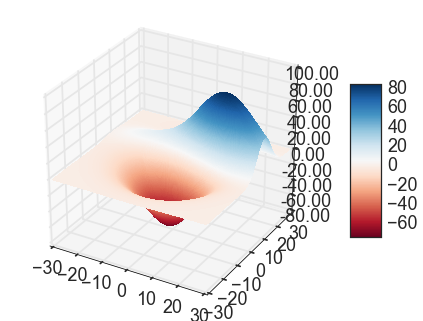

In [439]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
# generate 3D sample data
from mpl_toolkits import mplot3d
X,Y,Z = mplot3d.axes3d.get_test_data(.01)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [304]:
#X,Y = np.meshgrid(-8,.5,8);
R = sqrt(X**2 + Y**2) + eps;
Z = sin(R)/R;
surf(Z);

NameError: name 'sqrt' is not defined

In [11]:
sns.set(font_scale=1.8, style='white')
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))


rd1, ri1, dv1 = basic_network(Id=3.3, Ii=3.0, Io=1.5, rmax=60, b=30, g=14, wid=.24, wdi=.24, Z=20, si=1.5, k=1., tau=.1, dt=.005)
ax1.plot(rd1, color=colors[-5], alpha=1)
ax1.plot(ri1, color=colors[-5], alpha=.7)
ax2.plot(dv1, color=colors[-5],)

In [2]:
rd2, ri2, dv2 = basic_network(Id=3.9, Ii=3.0, Io=3.5, rmax=60, b=30, g=14, wid=.24, wdi=.24, Z=20, si=3, k=.9)
ax1.plot(rd2, color=colors[3], alpha=1)
ax1.plot(ri2, color=colors[3], alpha=.7)
ax2.plot(dv2, color=colors[3])
ax2.hlines(0,xmin=0,xmax=ax2.get_xlim()[-1], alpha=.4, lw=2, linestyles='--', color='k')
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_ylim(-4, 20)
sns.despine(right=True, top=False, ax=ax2)
sns.despine(ax=ax1)

NameError: name 'basic_network' is not defined

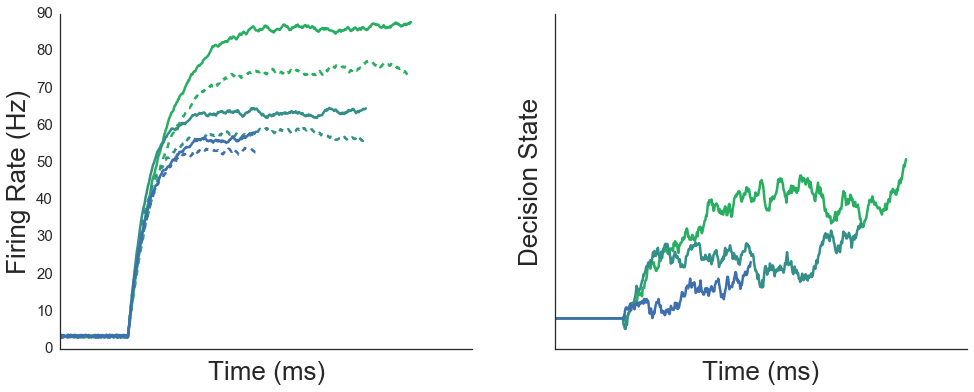

In [109]:
c=sns.blend_palette([colors[3], colors[6]], n_colors=10)
sns.set(style='white', font_scale=1.5)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
rd1, ri1, dv1 = basic_network(Id=3.7, Ii=2.7, Io=3., g=12, b=30, dt=.001, rmax=60, k=.9, wid=21, wdi=22, si=1.7)

rd2, ri2, dv2 = basic_network(Id=3.4, Ii=2.7, Io=3., g=11, b=30, dt=.001, rmax=60, wid=.21, wdi=.22, si=1.7, onmax=len(dv1))

rd3, ri3, dv3 = basic_network(Id=3.0, Ii=2.7, Io=3., g=9, b=30, dt=.001, rmax=60, wid=.21, wdi=.22, si=1.7, onmax=len(dv1))


ax1.plot(rd1[:len(dv1)], color=c[0], alpha=1, linewidth=2.5)
ax1.plot(ri1[:len(dv1)], color=c[0], linestyle='--', alpha=1, linewidth=2.5)

ax1.plot(rd2[:len(dv2)], color=c[4], alpha=1, linewidth=2.5)
ax1.plot(ri2[:len(dv2)], color=c[4], linestyle='--', alpha=1, linewidth=2.5)

ax1.plot(rd3[:len(dv3)], color=c[8], alpha=1, linewidth=2.5)
ax1.plot(ri3[:len(dv3)], color=c[8], linestyle='--', alpha=1, linewidth=2.5)

ax2.plot(dv1, color=c[0], alpha=1, linewidth=2.5)
ax2.plot(dv2, color=c[4], alpha=1, linewidth=2.5)
ax2.plot(dv3, color=c[8], alpha=1, linewidth=2.5)
ax1.set_ylabel('Firing Rate (Hz)', fontsize=26)
ax1.set_xlabel('Time (ms)', fontsize=26)
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_ylabel('Decision State', fontsize=26)
ax2.set_xlabel('Time (ms)', fontsize=26)
ax2.set_ylim(-2,20)
sns.despine(right=True, top=True, left=False, bottom=False, ax=ax1)
sns.despine(right=True, top=True, left=False, bottom=False, ax=ax2)

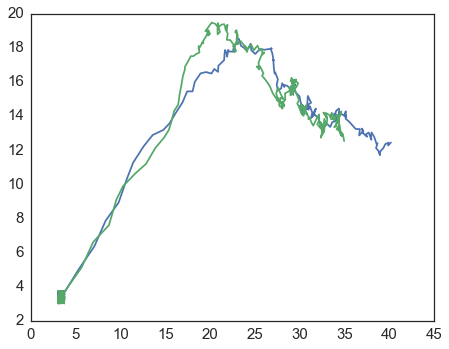

In [16]:
plt.plot(rd1[:len(dv1)], ri1[:len(dv1)])
plt.plot(rd3[:len(dv3)], ri3[:len(dv3)])

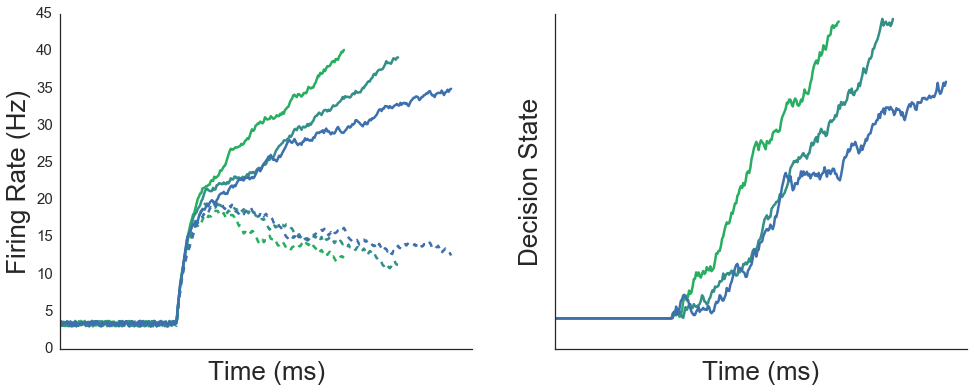

In [14]:
c=sns.blend_palette([colors[3], colors[6]], n_colors=10)
sns.set(style='white', font_scale=1.5)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
rd1, ri1, dv1 = basic_network(Id=3.7, Ii=2.7, Io=3., g=14, b=30, dt=.001, rmax=60, wid=.21, wdi=.22, si=1.7)

rd2, ri2, dv2 = basic_network(Id=3.4, Ii=2.7, Io=3., g=14, b=30, dt=.001, rmax=60, wid=.21, wdi=.22, si=1.7, onmax=len(dv1))

rd3, ri3, dv3 = basic_network(Id=3.0, Ii=2.7, Io=3., g=14, b=30, dt=.001, rmax=60, wid=.21, wdi=.22, si=1.7, onmax=len(dv1))


ax1.plot(rd1[:len(dv1)], color=c[0], alpha=1, linewidth=2.5)
ax1.plot(ri1[:len(dv1)], color=c[0], linestyle='--', alpha=1, linewidth=2.5)

ax1.plot(rd2[:len(dv2)], color=c[4], alpha=1, linewidth=2.5)
ax1.plot(ri2[:len(dv2)], color=c[4], linestyle='--', alpha=1, linewidth=2.5)

ax1.plot(rd3[:len(dv3)], color=c[8], alpha=1, linewidth=2.5)
ax1.plot(ri3[:len(dv3)], color=c[8], linestyle='--', alpha=1, linewidth=2.5)

ax2.plot(dv1, color=c[0], alpha=1, linewidth=2.5)
ax2.plot(dv2, color=c[4], alpha=1, linewidth=2.5)
ax2.plot(dv3, color=c[8], alpha=1, linewidth=2.5)
ax1.set_ylabel('Firing Rate (Hz)', fontsize=26)
ax1.set_xlabel('Time (ms)', fontsize=26)
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_ylabel('Decision State', fontsize=26)
ax2.set_xlabel('Time (ms)', fontsize=26)
ax2.set_ylim(-2,20)
sns.despine(right=True, top=True, left=False, bottom=False, ax=ax1)
sns.despine(right=True, top=True, left=False, bottom=False, ax=ax2)

In [101]:
f.savefig("/Users/kyle/Dropbox/BS_Rate_Competition_v3.png", dpi=600)

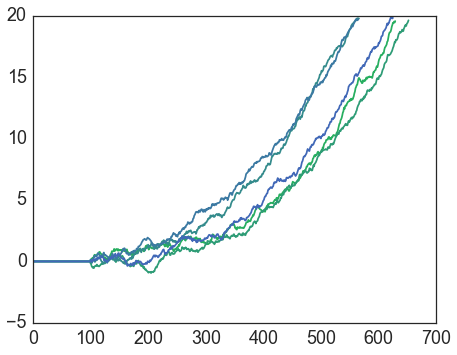

In [43]:
plt.plot(dv1, color=c[0])
plt.plot(dv2, color=c[1])
plt.plot(dv3, color=c[2])
plt.plot(dv4, color=c[3])
plt.plot(dv5, color=c[4])

In [15]:
ntrials=100
IoRT, rt = [], []
Io=4.; n=1
for Io in [4.5, 3.6, 2.7]:
      for tn in xrange(ntrials):
            rd, ri, dv = decision_network(Id=3.8, Ii=2.6, Io=Io, g=12, b=34, rmax=60, wid=.21, wdi=.21)
            if dv[-1]<19:
                  continue
            rt.append(len(dv))
      IoRT.append(np.asarray(rt))
#r, rt, nort = [np.asarray(x) for x in [r, rt, nort]]      

In [234]:
sns.set(style='white', font_scale=2.)
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,13))

IoRT, rt = [], []
Io=4.; n=1
for w in [[.20,.24], [.20,.27], [.20, .29]][::-1]:
      for tn in xrange(ntrials):
            rd, ri, dv = decision_network(Id=3.5, Ii=3., Io=4.5, g=12, b=34, rmax=60, wid=w[0], wdi=w[1])
            if np.shape(dv)[0]<19:
                  continue
            rt.append(len(dv))
      IoRT.append(np.asarray(rt))

rd1, ri1, dv1 = decision_network(Id=3.5, Ii=3., Io=4.5, g=12, b=34, rmax=60, wid=.20, wdi=.30)
rd2, ri2, dv2 = decision_network(Id=3.5, Ii=3., Io=4.5, g=12, b=34, rmax=60, wid=.20, wdi=.27)
rd3, ri3, dv3 = decision_network(Id=3.5, Ii=3., Io=4.5, g=12, b=34, rmax=60, wid=.20, wdi=.22)
data=[[rd1, ri1, dv1, 1, True], [rd2, ri2, dv2, .5, False], [rd3, ri3, dv3, .25, False]]
xlim=(0,len(rd1)+50)
for i, dat in enumerate(data):
      dual_space_plot(ax2, ax1, dat[0], dat[1], dat[2], alpha=dat[3], isfirst=dat[4], i=i, xlim=xlim)
plot_rt_distributions(ax2, ax1, np.asarray(IoRT), xlim)

In [21]:
sns.set(style='white', font_scale=2.)
IoRT, rt = [], []
Io=4.; n=1
for io in [4.5, 3.6, 2.8]:
      for tn in xrange(ntrials):
            rd, ri, dv = decision_network(Id=3.8, Ii=2.6, Io=io, g=13, b=34, rmax=60, wid=.21, wdi=.21)
            if np.shape(dv)[0]<19:
                  continue
            rt.append(len(dv))
      IoRT.append(np.asarray(rt))
      
      

In [26]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,13))
rd1, ri1, dv1 = decision_network(Id=3.8, Ii=2.6, Io=4.5, g=13, b=34, rmax=60, wid=.21, wdi=.21)
rd2, ri2, dv2 = decision_network(Id=3.8, Ii=2.6, Io=3.6, g=13, b=34, rmax=60, wid=.21, wdi=.21)
rd3, ri3, dv3 = decision_network(Id=3.8, Ii=2.6, Io=2.8, g=13, b=34, rmax=60, wid=.21, wdi=.21)
data=[[rd1, ri1, dv1, 1, True], [rd2, ri2, dv2, .5, False], [rd3, ri3, dv3, .25, False]]
xlim=(0,len(rd1)+150)
for i, dat in enumerate(data):
      dual_space_plot(ax2, ax1, dat[0], dat[1], dat[2], rts=None, alpha=dat[3], isfirst=dat[4], i=i, xlim=xlim)
plot_rt_distributions(ax2, ax1, rts=IoRT, xlim=xlim)

In [92]:
rd4, ri4, dv4 = basic_network(Ii=3.9, Id=2.6, Io=4.5, g=13, b=34, rmax=60, wid=.27, wdi=.27)
rd5, ri5, dv5 = basic_network(Ii=3.9, Id=2.6, Io=3.6, g=13, b=34, rmax=60, wid=.27, wdi=.27)
rd6, ri6, dv6 = basic_network(Ii=3.9, Id=2.6, Io=2.8, g=13, b=34, rmax=60, wid=.27, wdi=.27)


plt.plot(rd4, ri4, colors[6], alpha=1)
plt.plot(rd5, ri5, colors[6], alpha=.7)
plt.plot(rd6, ri6, colors[6], alpha=.5)

In [93]:
plt.plot(rd4, colors[3])
plt.plot(ri4, colors[6])
plt.plot(rd5, colors[3], alpha=.7)
plt.plot(ri5, colors[6], alpha=.7)
plt.plot(rd6, colors[3], alpha=.5)
plt.plot(ri6, colors[6], alpha=.5)

In [541]:
f.savefig('Choice_Explore_Exploit_decayIo.png', dpi=700)

In [40]:
np.ndim(np.vstack([rt]*2))

2

In [1]:
def dual_space_plot(ax1, ax2, rd, ri, dv, rts=None, Z=20, alpha=1, isfirst=True, xlabel=False, i=0, xlim=None):
      
      #f.subplots_adjust(hspace=.30)
      rt=len(dv)
      
      if isfirst:
            labels=['Direct', 'Indirect']
            ax1.set_xlabel('Time (ms)')
      else:
            labels=[None, None]
      ax1.plot(rd, label=labels[0], color=colors[3], alpha=alpha)
      ax1.plot(ri, label=labels[1], color=colors[6], alpha=alpha)
      ax1.vlines(rt, ymin=ri[rt], ymax=rd[rt], color=colors[-2], linestyles='--', alpha=alpha)
      
      # Decision Space
      ax2.plot(dv, color=colors[-2], alpha=alpha)

      if xlabel:
            ax1.set_xlabel('Time (ms)')

      ax1.set_ylabel('Firing Rate (Hz)')
      ax2.set_ylabel('Decision Evidence ($\Theta$)')
      
      
      ax1.set_yticks([0, int(hs([rd, ri]).max())+5])
      for ax in [ax1, ax2]:
            ax.set_yticklabels([])
            ax.set_xticks(xlim)
            ax.set_xticklabels(xlim)
            
      ax2.set_ylim(-1,Z)
      ax1.legend(loc=2)
      ax2.hlines(Z, 0, ax2.get_xlim()[1], linestyle='--')

      f.subplots_adjust(hspace=0.1)
      sns.despine(ax=ax1)
      sns.despine(top=True, ax=ax2)
      if xlim is not None:
            ax1.set_xlim(xlim[0], xlim[1])
            ax2.set_xlim(xlim[0], xlim[1])


In [17]:
def plot_rt_distributions(ax1, ax2, rts, xlim=None, a=.8):
      
      divider = make_axes_locatable(ax2)                                   
      axx = divider.append_axes("top", size=1.6, pad=0.01, sharex=ax1)
      for rt in rts:
            sns.kdeplot(rt, ax=axx, shade=True, color=colors[-2], alpha=a)
            a=a-.3
      for spine in ['top', 'left', 'bottom', 'right']:
            axx.spines[spine].set_visible(False)
      
      axx.set_xticklabels([]); 
      axx.set_yticklabels([])
      
      if xlim is not None:
            ax2.set_xlim(xlim[0], xlim[1])
            axx.set_xlim(xlim[0], xlim[1])


In [45]:
def vectorize_params(p, pc_map, ncond=1):
    pvc = ['a', 'tr', 'vd', 'vi', 'xb']
    for pkey in pvc:
        p[pkey]=p[pkey]*np.ones(ncond)
    for pkey, pkc in pc_map.items():
        if ncond==1:
            p[pkey]=np.asarray([p[pkey]])
            break
        elif pkc[0] not in p.keys():
            p[pkey] = p[pkey]*np.ones(len(pkc))
        else:
            p[pkey] = array([p[pc] for pc in pkc])
        return p

def update_execution(p):
    """ update Pg (probability of DVg +dx) and Tg (num go process timepoints)
    for go process and get get dynamic bias signal if 'x' model
    """
    #Pex = 0.5*(1 + (p['vd']/p['vi'])*dx/si)
    Pd = 0.5*(1 + p['vd']*dx/si)
    Pi = 0.5*(1 + p['vi']*dx/si)
    Tex = np.ceil((tb-p['tr'])/dt).astype(int)

    return Pd, Pi, Tex

In [46]:
pc_map={'vd': ['vd_e', 'vd_u', 'vd_l'], 'vi': ['vi_e', 'vi_u', 'vi_l']}
p['vd']=p['v']*1.41
p['vi']=p['v']*.4
p['a']=.6

nc=3
px = vectorize_params(p, pc_map, ncond=nc)
si=.1

In [159]:
exproc = di_decision(p)

In [178]:
winners = np.argmin(exproc, 0)
rts = [exproc[winner_ix, i] for i, winner_ix in enumerate(winners)]

In [179]:
rts


[0.51812599999999998, 0.44612600000000002, 0.42912600000000001]

In [177]:
exproc

array([[ 0.55113,  0.44613,  0.54413],
       [ 0.51813,  0.55113,  0.66713],
       [ 1.05013,  0.57713,  0.42913],
       [ 0.76213,  0.54713,  0.56713]])

In [173]:
exproc[0]

array([ 0.55113,  0.44613,  0.54413])

In [169]:
exproc[winner_ix]

array([[ 0.51813,  0.55113,  0.66713],
       [ 0.55113,  0.44613,  0.54413],
       [ 1.05013,  0.57713,  0.42913]])

In [161]:
exproc

array([[ 0.55113,  0.44613,  0.54413],
       [ 0.51813,  0.55113,  0.66713],
       [ 1.05013,  0.57713,  0.42913],
       [ 0.76213,  0.54713,  0.56713]])

In [110]:
exproc.shape

(4, 3)

In [109]:
for i in range(nc):
    for ii in range(4):
        plt.plot(exproc[0, ii, :])


IndexError: too many indices for array

In [58]:
p['tr'][na, :].shape

(1, 3)

In [127]:
p

{'a': array([ 1.5,  1.5,  1.5]),
 'tr': array([ 0.29213,  0.29213,  0.29213]),
 'v': 1.718,
 'vd': array([ 1.73518,  1.73518,  1.73518]),
 'vi': array([ 1.70082,  1.70082,  1.70082]),
 'xb': array([ 1.51129,  1.51129,  1.51129])}

In [91]:
si=.1

In [183]:
pc_map.values()[0]


['vi_e', 'vi_u', 'vi_l']

In [184]:
tb

1.5

In [104]:
def rew_func(rprob): 
    if rs()<rprob:
        return 1
    else:
        return 0


def multi_response(p, nresp=4):

    p = vectorize_params(p, pc_map=pc_map, ncond=nc)

    Pd = 0.5*(1 + p['vd']*dx/si)
    Pi = 0.5*(1 + p['vi']*dx/si)

    Tex = np.ceil((tb-p['tr'])/dt).astype(int)
    #state = np.where(rs(ntot)>.5, 'l', 'r')
    #state=np.sort(state)

    Pd, Pi, Tex = update_execution(p)
    xtb = temporal_dynamics(p, np.cumsum([dt]*Tex.max()))

    direct = np.where((rs((nc, nresp, Tex.max())).T < Pd),dx,-dx).T
    indirect = np.where((rs((nc, nresp, Tex.max())).T < Pi),dx,-dx).T
    execution = xtb[0] * np.cumsum(direct-indirect, axis=2)
    execution = execution.reshape(nresp, nc, Tex.max())
    
    winner=np.nan
    while np.isnan(choice):
        winner, rt, p = analyze_execution(execution, p, dt)
    
    return int(winner), rt


def analyze_multiresponse(execution, p, ):

    rt = array([p['tr'] + np.argmax((resp_x.T>=p['a']).T, axis=1)*dt for resp_x in execution])
    # set non responses to 999
    rt[rt==p['tr'][0]]=999
    # get accumulator with fastest RT (winner) in each cond
    winners = np.argmin(rt[rt<999], 0)
    # get rt of winner in each cond
    rts = array([rt[winner_ix, i] for i, winner_ix in enumerate(winners)])
    if np.all(rt==999):
        p['a']=p['a']*.99
        return np.nan, p
    
    return winners, rt, p

In [34]:
dt

0.001

In [ ]:
lca(I, k, w, [Rd[tn, -1], Ri[tn, -1]]

In [ ]:
lca = lambda I, k, w, r: I+(k*r[0])+(w.T*r[1:])
Rd[tn,i-1]+a(I, k, w, [Rd[tn, -1], Ri[tn, -1]])-ithresh)/idelta))-Rd[tn,i-1])+Ed[i]

In [1]:
nsims=20
sns.set(style='dark', font_scale=1.8, rc={"axes.facecolor": "white"})
f, ax = plt.subplots(1, figsize=(8,7))

di_cmap = mpl.colors.ListedColormap(sns.blend_palette([colors[6], colors[3]], n_colors=nsims))
d=np.linspace(2, 6., nsims)
diratio=np.linspace(-1,1,len(d))

norm = mpl.colors.Normalize(
    vmin=np.min(diratio),
    vmax=np.max(diratio))

sm = mpl.cm.ScalarMappable(cmap=di_cmap, norm=norm)
sm.set_array([])
r=[]
for i, rate in enumerate(d):
      r1, r2, dv  = basic_network(Id=rate, Ii=4., Io=4., k=.95, wdi=.22, wid=.22, ntrials=1, si=.3, b=30, rmax=65, g=12.6, dt=.001)
      ax.plot(r1, r2, color=sm.to_rgba(diratio[i]), alpha=.5)
      r.append([r1, r2])
plt.colorbar(sm, ax=plt.gca())
rmax=70
ax.plot([0,rmax], [0,rmax], color='k', alpha=.3, linestyle='--', lw=2.5)
ax.set_ylabel('Skeptic (Hz)')
ax.set_xlabel('Believer (Hz)')
ax.set_ylim(0,rmax)
ax.set_xlim(0,rmax)
ax.set_xticks([0,rmax])
ax.set_xticklabels([0,rmax])
ax.set_yticks([0,rmax])
ax.set_yticklabels([0,rmax])
#f.savefig('di_nn_noiseless.png', dpi=600)

ValueError: style must be one of white, dark, whitegrid, darkgrid, ticks

In [696]:
import matplotlib as mpl # in python
cm = mpl.colors.ListedColormap(C/255)
imshow(..., cmap=cm) # for example

[<matplotlib.text.Text at 0x110fe8b50>, <matplotlib.text.Text at 0x111207c10>]

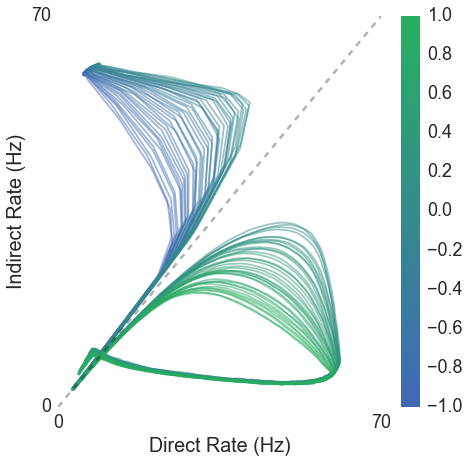

In [30]:
nsims=80
sns.set(style='dark', font_scale=1.8, rc={"axes.facecolor": "white"})
f, ax = plt.subplots(1, figsize=(8,7))

di_cmap = mpl.colors.ListedColormap(sns.blend_palette([colors[6], colors[3]], n_colors=nsims))
d=np.linspace(3, 8., nsims/2)
d=np.hstack([d, d[::-1]])
diratio=np.linspace(-1,1,len(d))

norm = mpl.colors.Normalize(
    vmin=np.min(diratio),
    vmax=np.max(diratio))

sm = mpl.cm.ScalarMappable(cmap=di_cmap, norm=norm)
sm.set_array([])
r,dvlist=[],[]

#w=np.linspace(3,7,nsims*2)

for i, rate in enumerate(d):
      if i < (nsims/2.):
            r1, r2, dv  = basic_network(Id=3.0, Ii=3.0, Io=rate, k=.98, wi=1.5, wd=1.2, wdi=.26, wid=.28, ntrials=1, si=.3, b=30, rmax=65, g=14.5)      
            ax.plot(r1, r2, color=sm.to_rgba(diratio[i]), alpha=.5)
            r.append([r1, r2])
            dvlist.append(dv)

      if i > (nsims/2.):
            r1, r2, dv  = basic_network(Id=3.0, Ii=3.0, Io=rate, k=.98, wd=1.5, wi=1.2, wdi=.28, wid=.26, ntrials=1, si=.3, b=30, rmax=65, g=14.5, dt=.001)
            ax.plot(r1, r2, color=sm.to_rgba(diratio[i]), alpha=.5)
            r.append([r1, r2])
            dvlist.append(dv)
plt.colorbar(sm, ax=plt.gca())
rmax=70
ax.plot([0,rmax], [0,rmax], color='k', alpha=.3, linestyle='--', lw=2.5)
ax.set_ylabel('Indirect Rate (Hz)')
ax.set_xlabel('Direct Rate (Hz)')
ax.set_ylim(0,rmax)
ax.set_xlim(0,rmax)
ax.set_xticks([0,rmax])
ax.set_xticklabels([0,rmax])
ax.set_yticks([0,rmax])
ax.set_yticklabels([0,rmax])
#f.savefig('di_nn_noiseless.png', dpi=600)

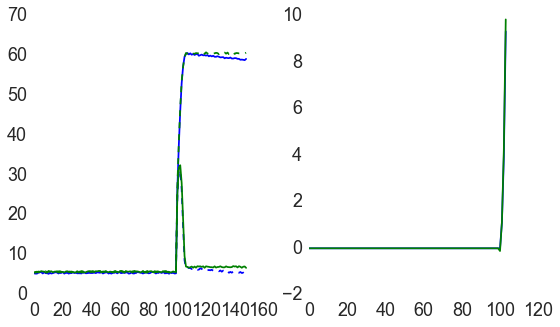

In [25]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.plot(r[60][0], color='Blue')
ax1.plot(r[60][1], linestyle='--', color='Blue')
ax1.plot(r[20][0], color='Green')
ax1.plot(r[20][1], linestyle='--', color='Green')

ax2.plot(dvlist[-10], color='Blue')
ax2.plot(dvlist[-20], color='Green')

In [19]:
r=[]
dvlist=[]
d=np.linspace(1, 6., nsims)
for i, rate in enumerate(d):
      r1, r2, dv  = basic_network(Id=2.3, Ii=2., Io=rate, k=.95, wdi=.3, wid=.3, ntrials=1, si=1.5, b=30, rmax=60, g=13)
      r.append([r1, r2])
      dvlist.append(dv)


NameError: name 'nsims' is not defined

NameError: name 'nsims' is not defined

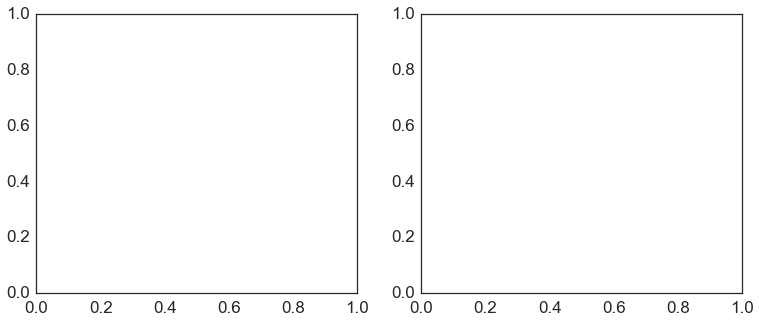

In [18]:
sns.set(style='white', font_scale=1.7)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5), sharex=False, sharey=False)
c=sns.blend_palette([colors[6], colors[3]], n_colors=nsims)

ax1.plot(r[-1][0], color=c[-1], linestyle='-', lw=2.5)
ax1.plot(r[-1][1], color=colors[6], linestyle='-', lw=2.5)

#ax1.plot(r[-9][0], color=c[-6], linestyle='-', lw=2.5)
#ax1.plot(r[-9][1], color=colors[6], linestyle='-', lw=2.5)

ax1.plot(r[-12][0], color=c[-12], linestyle='-', lw=2.5)
ax1.plot(r[-12][1], color=colors[6], linestyle='-', lw=2.5)

ax1.plot(r[-13][0], color=c[-13], linestyle='-', lw=2.5)
ax1.plot(r[-13][1], color=colors[6], linestyle='-', lw=2.5)

ax2.plot(dvlist[-2], color=colors[3], linewidth=2.5)
#ax2.plot(dvlist[-9], color=c[-6], linewidth=2.5)
ax2.plot(dvlist[-12], color=c[-12], linewidth=2.5)
ax2.plot(dvlist[-13], color=c[-13], linewidth=2.5)

sns.despine()

ax1.set_ylabel('Population Firing Rate (Hz)', fontsize=20)
ax1.set_xlabel('Time (ms)', fontsize=20)

ax2.set_ylabel('Decision Evidence', fontsize=20)
ax2.set_xlabel('Time (ms)', fontsize=20)
ax2.set_ylim(0,20)
ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax1.set_xlim(0,800)
ax2.set_xlim(0,800)

ax2.vlines(x=799, ymin=0, ymax=20, lw=4, color='k', alpha=.4, linestyle='--')
#ax2.hlines(y=20, xmin=0, xmax=800, lw=4, color='k', linestyle='-')
sns.despine(ax=ax2, top=False, bottom=False, left=False, right=True)

In [525]:
nsims=50
r=[]
dvlist=[]
d=np.linspace(1, 6., nsims)
for i, rate in enumerate(d):
      r1, r2, dv  = basic_network(Id=2.3, Ii=2., Io=rate, k=.95, wdi=.24, wid=.22, ntrials=1, si=1.5, b=30, rmax=60, g=12.5)
      r.append([r1, r2])
      dvlist.append(dv)

In [526]:
sns.set(style='white', font_scale=1.7)

f, (ax2, ax1) = plt.subplots(2, 1, figsize=(7,11), sharex=False, sharey=False)
c=sns.blend_palette([colors[6], colors[3]], n_colors=nsims)
x=np.arange(100, 800)
ax1.plot(x, r[-1][0][100:800], color=c[-1], linestyle='-', lw=2.5)
ax1.plot(x, r[-1][1][100:800], color=colors[6], linestyle='-', lw=2.5)

ax1.plot(x, r[-30][0][100:800], color=c[-12], linestyle='-', lw=2.5)
ax1.plot(x, r[-30][1][100:800], color=colors[6], linestyle='-', lw=2.5)

ax1.plot(x, r[-45][0][100:800], color=c[-13], linestyle='-', lw=2.5)
ax1.plot(x, r[-45][1][100:800], color=colors[6], linestyle='-', lw=2.5)
#ccc=[c[-1], c[-5], c[-9], c[-11]]
a=[1, .9, .7, .5]
for i, rr in enumerate([r[::-1][1], r[::-1][25], r[::-1][48]]):
      cc=ccc[i]
      ax1.plot(rr[0][:100], color="#FF6700", lw=2.5, alpha=a[i])


ax2.plot(dvlist[-1], color=colors[3], linewidth=2.5)
ax2.plot(dvlist[-30], color=c[-25], linewidth=2.5)
ax2.plot(dvlist[-48], color=c[-30], linewidth=2.5)

sns.despine()

ax1.set_ylabel('Population Firing Rate (Hz)', fontsize=20)
ax1.set_xlabel('Time (ms)', fontsize=20)

ax2.set_ylabel('Decision Evidence', fontsize=20)
#ax2.set_xlabel('Time (ms)', fontsize=20)
ax2.set_ylim(0,20)
ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax1.set_xlim(0,800)
ax2.set_xlim(0,800)

ax2.vlines(x=799, ymin=0, ymax=20, lw=4, color='k', alpha=.4, linestyle='--')
#ax2.hlines(y=20, xmin=0, xmax=800, lw=4, color='k', linestyle='-')
sns.despine(ax=ax2, top=False, bottom=False, left=False, right=True)

In [507]:
f.savefig('bs_decision_baseline_tall.png', dpi=600)

In [410]:
sns.set(font_scale=1.5)
f, ax = plt.subplots(1)
a=np.arange(10)*.1
c=sns.blend_palette([colors[10],colors[3]], n_colors=nsims)
for i in range(24):          
      r1, r2 = di_lca(Id=i, Ii=1, ntrials=1, si=10)
      if r1[0,-1]>=r2[0,-1]:
            c=colors[10]
      else:
            c=colors[-5]
      ax.plot(r1[0,:], r2[0,:], color=c)
      #ax.plot(r2[0,:], color=colors[3])
#ax.set_xlim(0,300)
ax.set_ylabel('$r_{I}$')
ax.set_xlabel('$r_{D}$')
ax.set_title('Noisy Competing Attractor Network')
plt.tight_layout()
sns.despine()
#f.savefig('di_nn_noisy_attractor.png', dpi=500)

In [25]:
sns.set(font_scale=1.5)
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), sharey=False)
r1, r2 = di_lca(p, Id=5., Ii=3., ntrials=10, idelta=22, Wi=-.20, Wd=-.20, tau=.05, k=.9, ithresh=45, rmax=90, si=5)

r3, r4 = di_lca(p, Id=5., Ii=4., ntrials=10, idelta=22, Wi=-.20, Wd=-.20, tau=.05, k=.9, ithresh=45, rmax=90, si=5)

for i, (xd, xi) in enumerate(zip(r1, r2)):
      if i==0:
            a=1
      else:
            a=.03
            
      ax1.set_title('STR', fontsize=19)
      ax1.plot(xd, color=colors[7], alpha=a, label='dMSN')
      ax1.plot(xi, color=colors[4], alpha=a, label='iMSN')
      
      ax1.plot(r3[i, :], color=colors[-5], alpha=a, label='dMSN')
      ax1.plot(r4[i, :], color=colors[-9], alpha=a, label='iMSN')
      
      ax1.set_ylim(0,100)
      ax1.set_ylabel('$sp/s^-1$')


      ax2.set_title('GPi', fontsize=19)
      delta_di = (xd-xi)/np.sqrt(3)
      rt = np.argmax(delta_di>=35)
      
      delta_di34 = (r3[i, :]-r4[i, :])/5
      rt34 = np.argmax(delta_di34>=35)
      
      ax2.plot(delta_di[:rt], color='b', alpha=a)
      ax2.plot(delta_di34[:rt34], color='r', alpha=a)
      
      ax2.hlines(35,0,600,linestyle='--')
      ax2.vlines(rt,0,45,linestyle='-', color='b', lw=.4, alpha=a)
      ax2.vlines(rt34,0,45,linestyle='-', color='r', lw=.4, alpha=a)
      ax1.set_xlabel('Time (ms)')
      ax2.set_xlabel('Time (ms)')
      
      ax2.set_ylim(0,45)
      plt.tight_layout()
      sns.despine()

#f.savefig('DI_LCA_STR-GPi_Reward.png', dpi=500)

NameError: name 'di_lca' is not defined

In [225]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(r2[0,:], r1[0,:], r3[0,:], color=c[i])

{'a': array([ 0.26144,  0.26144]),
 'tr': array([ 0.29213,  0.29213]),
 'vd': array([ 5.     ,  1.47766]),
 'vi': array([ 0.08114,  4.79747]),
 'xb': 3.5}

In [379]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sns.set(font_scale=1.5)
#f, ax = plt.subplots(1)
#fig = plt.figure()
#ax = fig.gca(projection='3d')
a=np.arange(50)*.1
c=sns.blend_palette([colors[-3], colors[-5], colors[10]], n_colors=50, input='rgb')

for i in range(50):
      
      r1, r2, r3 = di_lca(ntrials=10, si=12)
      #color=c[array([r1[0,-1], r2[0,-1], r3[0,-1]]).argmin()]
      #r1, r2 = di_lca(p, Iapp1=15.5, Iapp2=15.5, ntrials=10, si=.001)
      ax.scatter(r2[0,:], r1[0,:], r3[0,:], color=c[i])

ax.set_ylabel('$r_{I}$')
ax.set_xlabel('$r_{D}$')
ax.set_title('Recurrent Competing Attractor Network')
plt.tight_layout()
#sns.despine()
#f.savefig('di_nn_attractor.png', dpi=500)

In [39]:
def rew_func(rprob): 
      if rs()<rprob:
            return 1
      else:
            return 0


def di_decision(p):
      
      p = vectorize_params(p, pc_map=pc_map, ncond=nc)
      
      Pd = 0.5*(1 + p['vd']*dx/si)
      Pi = 0.5*(1 + p['vi']*dx/si)
      
      Tex = np.ceil((tb-p['tr'])/dt).astype(int)
      #state = np.where(rs(ntot)>.5, 'l', 'r')
      #state=np.sort(state)

      Pd, Pi, Tex = update_execution(p)
      xtb = temporal_dynamics(p, np.cumsum([dt]*Tex.max()))
      
      direct = xtb*np.where((rs((nc, Tex.max())).T < Pd),dx,-dx).T
      indirect = np.where((rs((nc, Tex.max())).T < Pi),dx,-dx).T
      execution = np.cumsum(direct-indirect, axis=1)
      
      choice=np.nan
      while np.isnan(choice):
            choice, p = analyze_execution(execution, p)
      
      return int(choice), execution
      
      
def analyze_execution(execution, p):
      
      rt = p['tr'] + np.argmax((execution.T>=p['a']).T, axis=1)*dt
      rt[rt==p['tr'][0]]=0

      #rt[rt>0] = p['tr'][0]+rt[rt>0]
      #rt[rt==0] = 999
      #rt = p['tr']+(rx*np.where(rx==0, 999, 1))
      
      
      if np.all(rt==0):
            p['a']=p['a']*.999
            #p['xb']=p['xb']*1.01
            return np.nan, p
      else:
            p['a']=p['a']*1.001
            return rt.argmin(), p

In [76]:
si=0.01

In [8]:
stim=[['a', 'b'], ['c', 'd'], ['e', 'f']]

x= np.asarray(stim).flatten().tolist()

In [11]:
''.join(x)

'abcdef'

In [70]:
stim = [['a','b'], ['c', 'd'], ['e','f']]
pc_map = {'vd':['v_0', 'v_1'], 'vi': ['v_0', 'v_1']}
ntrials=90
p['vd']=[.9, .9]; p['vi']=[.4, .4]
p['a'] = .45
p['xb'] = 2.85
try:
      p.pop('v')
except Exception:
      pass

plist = [deepcopy(p) for i in xrange(len(stim))]
plist = [vectorize_params(p, pc_map, 2) for p in plist]

rand_stim = sum([sorted([0,1,2], key=lambda k: random.random()) for i in xrange(ntrials)], [])

preward = [.85,.75,.65]
nsuccess = 0
alpha_pos = .1
alpha_neg = .1
alpha=.06
traces = []

x = np.sort(uniform.rvs(0,1,1000))
prior = uniform.pdf(x)

stim_ids='abcdef'
ru = {sid: deepcopy(prior) for sid in stim_ids}     
stim_history = {sid: [0, 0] for sid in stim_ids}     
qdict = {sid: [.01] for sid in stim_ids}
di_qvals= {sid: {'vd':[.9], 'vi':[.4]} for sid in stim_ids}
exdict = {sid: [] for sid in stim_ids}


for trial_n, i in enumerate(rand_stim):
      
      #if trial_n==int(.5*ntrials):
      #      preward=[.2,.3,.4]
      
      stim_pair_t = stim[i]
      stim_pair_qval = np.asarray([qdict[spt][-1] for spt in stim_pair_t])
      
      di_theta = plist[i]
      choice, execution_process = di_decision(di_theta)
      
      xchoice = abs(1-choice)
      traces.append(execution_process)
      
      if choice==0:
            r = rew_func(preward[i])
      else:
            r = rew_func(1-preward[i])
      
      # ID of chosen stimulus
      choice_id = stim_pair_t[choice]
      xchoice_id = stim_pair_t[xchoice]
      # update count (no. of times action has been chosen)
      stim_history[choice_id][0]+=1        
      
      #store decision traces
      exdict[choice_id].append(execution_process[choice])
      exdict[xchoice_id].append(execution_process[xchoice])
      
      # update chosen action value
      update_q = stim_pair_qval[choice] + alpha*(r-stim_pair_qval[choice])
      qdict[choice_id].append(update_q)
      qdict[xchoice_id].append(stim_pair_qval[xchoice])
      
      if r:
            # update nsuccess for chosen action
            stim_history[choice_id][1]+=1
            di_theta['vd'][choice] = di_theta['vd'][choice]+di_theta['vd'][choice]*update_q
            di_theta['vi'][choice] = di_theta['vi'][choice]-di_theta['vi'][choice]*(update_q*.5)
            if di_theta['vd'][choice]<0:
                  di_theta['vd'][choice]=.01
            if di_theta['vd'][choice]>=5.0:
                  di_theta['vd'][choice]=5.0
                  
      else:
            di_theta['vd'][choice] = di_theta['vd'][choice]-di_theta['vd'][choice]*(update_q*.5)
            di_theta['vi'][choice] = di_theta['vi'][choice]+di_theta['vi'][choice]*update_q
            
            if di_theta['vi'][choice]<0:
                  di_theta['vi'][choice]=.01
            if di_theta['vi'][choice]>=5.0:
                  di_theta['vi'][choice]=5.0
                  
      di_qvals[stim_pair_t[choice]]['vd'].append(di_theta['vd'][choice])
      di_qvals[stim_pair_t[choice]]['vi'].append(di_theta['vi'][choice])
      
      # extract action total count (n), nsuccess (s)
      n, s = stim_history[choice_id]
      #xn, xs = stim_history[xchoice_id]
      # estimate posterior uncertainty in action value (from prior)
      ru[choice_id] = (likelihood(prop(n, s), x, n, s)*ru[choice_id])#/((likelihood(prop(n+1, s), x, n, s)*ru[choice_id])+(likelihood(prop(xn+1, xs), x, xn, xs)*ru[xchoice_id]))
exdict = {sid: np.asarray(exdict[sid]) for sid in exdict.keys()}

In [71]:
sns.set(font_scale=1.7, style='ticks')
f, ax = plt.subplots(1, figsize=(10,6))

for k in qdict.keys():
      qdict[k]=np.asarray(qdict[k])

plt.plot(qdict['a']-qdict['b'], label='P(r | $a_{opt}$)=.8', color=flatui[2], marker='o', ms=7)
#plt.plot(qdict['b'], label='A.II (20)', color=flatui[2], ls='--')

plt.plot(qdict['c']-qdict['d'], label='P(r | $a_{opt}$)=.7', color=flatui[1], marker='o', ms=7)
#plt.plot(qdict['d'], label='B.II (30)', color=flatui[1], ls='--')

plt.plot(qdict['e']-qdict['f'], label='P(r | $a_{opt}$)=.6', color=flatui[0], marker='o', ms=7)
#plt.plot(qdict['f'], label='C.II (40)', color=flatui[0], ls='--')
plt.legend(loc=2, fancybox=True, frameon=True, framealpha=.8)
#plt.gca().text(2, .9, 'Pairs of Actions (a)', fontsize=13)
ax=plt.gca()
ax.set_ylabel("Q("+'$a_{opt}$'+")"+" - "+"Q("+'$a_{sub}$'+")", fontsize=23)
ax.set_xlabel('Trials', fontsize=23)
ax.set_ylim(0,.75)
ax.set_yticks([0, .75])
ax.set_yticklabels([0, .75])
ax.set_xticks([0,90])
ax.set_xticklabels([0,90])

sns.despine()
#plt.savefig('probabilistic_qlearning_diexplorer2.png', dpi=600)

In [75]:

#plt.plot(exdict['a'][-1], label='a')
#plt.plot(exdict['b'][-1], label='b')

plt.plot(exdict['e'][-10], label='a')
plt.plot(exdict['f'][-1], label='b')
plt.plot(qdict['c'][-1], label='c')
plt.plot(qdict['d'][1], label='d')

#plt.plot(qdict['e'], label='e')
#plt.plot(qdict['f'], label='f')
plt.legend()

In [30]:
plt.plot(qdict['a'], label='a')
plt.plot(qdict['b'], label='b')

plt.plot(qdict['c'], label='c')
plt.plot(qdict['d'], label='d')

plt.plot(qdict['e'], label='e')
plt.plot(qdict['f'], label='f')
plt.legend()

In [37]:
f, (ax1, ax2)=plt.subplots(2,1)
ax1.set_color_cycle(sns.color_palette('Reds', 2))
for i in traces[1]:
      ax1.plot(i)
ax2.set_color_cycle(sns.color_palette('Blues', 2))
for i in traces[-2]:
      ax2.plot(i, )

In [97]:
p = vectorize_params(p, pc_map=pc_map, ncond=nc)
Acc, RT, Resp, Vd, Vi, Ex = [], [], [], [], [], []
#state = np.where(rs(ntot)>.5, 'l', 'r')
#state=np.sort(state)
state=np.hstack([np.sort(['l', 'r']*20)]*3)
for i in xrange(len(state)):

    Pd, Pi, Tex = update_execution(p)
    direct = np.where((rs((nc, Tex.max())).T < Pd),dx,-dx).T
    indirect = np.where((rs((nc, Tex.max())).T < Pi),dx,-dx).T
    execution = np.cumsum(direct-indirect, axis=1)

    resp, rts, acc, p = analyze_execution(execution, p, trial_state=state[i])
    Acc.append(acc); Resp.append(resp); RT.append(rts)
    Vd.append(deepcopy(p['vd'])); Vi.append(deepcopy(p['vi']))                            
Acc=np.asarray(Acc)
RT=np.asarray(RT)
Resp=np.asarray(Resp)
Vd=np.asarray(Vd)    
Vi=np.asarray(Vi)    

In [975]:
f, ax = plt.subplots(1) 

rt_tminus1=RT[4].min()
for i, trial_rt in enumerate(RT):
      
      if trial_rt.min()==999:
            continue
            
      c='r'; ix=1
      if state[i]=='l':
            c='b'; ix=0
      if state[i-1]!=state[i]:
            c='White'
      ax.plot([i, i+1], [rt_tminus1, trial_rt[ix]], color=c)
      rt_tminus1=trial_rt[ix]

sns.despine()

In [189]:
sns.set(font_scale=1.4, style='white')
f, ax = plt.subplots(1)
flatui=[colors[4], colors[3], colors[-7]]
c=[flatui[0], flatui[0], flatui[1], flatui[1], flatui[2], flatui[2]]
ls=['-', '--']*3
for i, s in enumerate('abcdef'):
      y = (ru[s]-np.mean(ru[s]))/ru[s].std()
      ax.plot(x, y, label=s, linestyle=ls[i], color=c[i])
ax.legend()
ax.set_ylabel('$P(\Theta)$')
ax.set_xlabel('$Q(a_j)$')

sns.despine()
plt.tight_layout()

#plt.savefig('posterior_distributions_actionvalue_surprise.png')

TypeError: 'NoneType' object is not iterable

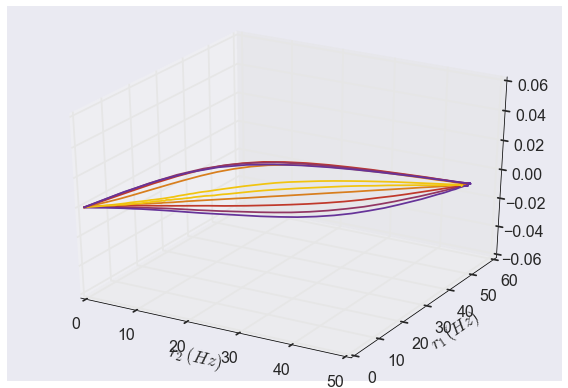

In [28]:
nsims=5
sns.set(font_scale=1.6)
from mpl_toolkits.mplot3d import Axes3D
f = plt.figure()
ax = f.add_subplot(111, projection='3d')
#ad=ai[::-1]
c=sns.blend_palette([colors[-3], colors[-5],colors[10]], n_colors=nsims)
def plot_func():
    for ii in range(2):
        for i, rate in enumerate(np.linspace(1, 50., nsims)):
            if ii==0:
                Id=rate; Ix=2.; Ii=2.
            elif ii==1:
                Ii=rate; Id=2.; Ix=2.

            r1, r2 = di_lca(Id=rate*.15, Ii=Ii, Ix=Ix, k=1, g=10, b=27, rmax=50, tau=.04, Wx=.25, Wi=.25, Wd=.25, Io=0, ntrials=1, si=.3)
            ax.plot(r1[0,:], r2[0,:], color=c[i])

            #ax.plot([0,100], [0,100], color='k')
            ax.set_ylabel('$r_{1}\/(Hz)$')
            ax.set_xlabel('$r_{2}\/(Hz)$ ')
            #ax.set_zlabel('$r_{3}\/(Hz)$ ')
            #ax.set_xticks([])
            #ax.set_xticklabels([])
            #ax.set_yticks([])
            #ax.set_yticklabels([])
            #ax.set_zticks([])
            #ax.set_zticklabels([])

            #ax.set_title('Noiseless Competing Attractor Network')
            plt.tight_layout()
            #sns.despine()
            #f.savefig('di_nn_pop3_noiseless.png', dpi=500)

def animate(ii):
    ax.view_init(elev=7, azim=ii)
    ii+=1
    return ax
ii=0
#plot_func()
# Animate
anim = animation.FuncAnimation(f, animate, init_func=plot_func, frames=np.arange(15), fargs=ii, interval=1, blit=True)
#animation.FuncAnimation(f, animate, init_func=plot_func, frames=50, interval=5, blit=True)
# Save
#anim.save('dpm_anim.mp4', dpi=300, fps=80, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])


In [280]:
p = vectorize_params(p, pc_map=pc_map, ncond=nc)
#Ph, Th = update_brake(p)
#ss_index = [np.where(Th<Tex[c],Tex[c]-Th,0) for c in range(nc)]
#return Pd, Pi
acc, rts, rsp, vd, vi, ex = [], [], [], [], [], []
for i in xrange(ntot):

      Pd, Pi, Tex = update_execution(p)
      #execution = np.cumsum(np.where((rs((nc, Tex.max())).T < Pex),dx,-dx).T, axis=1)
      direct = np.where((rs((nc, Tex.max())).T < Pd),dx,-dx).T
      indirect = np.where((rs((nc, Tex.max())).T < Pi),dx,-dx).T
      execution = np.cumsum(direct-indirect, axis=1)

      rx = np.argmax((execution.T>=p['a']).T, axis=1)*dt
      rt = p['tr']+(rx*np.where(rx==0, 999, 1))
      r = np.where(rt==rt.min(), 1, 0)
      
      #if i<25:
      if np.any(rt)<.3:
            continue
      elif r[0] and state[i]=='l':
            acc.append(1)
            p['vd'][0]=p['vd'][0] + p['vd'][0]*lr
      elif r[0] and state[i]=='r':
            acc.append(0)
            p['vi'][0]=p['vi'][0] + p['vi'][0]*lr  

      # find conditions where response was recorded
      #for ci in np.where(~np.isnan(rt))[0]:
      #p['vd']=p['vd'] + p['vd']*lr[0]
      #p['vi']=p['vi'] - p['vi']*lr[1]



      vd.append(deepcopy(p['vd']))
      vi.append(deepcopy(p['vi']))
      rts.append(rt)
      rsp.append(r)
      ex.append(execution)

vd = np.asarray(vd)
vi = np.asarray(vi)
rts = np.asarray(rts)
ex = np.asarray(ex)
rsp = np.asarray(rsp)

In [79]:
p = theta.get_default_inits(kind='pro', depends_on={'v':'pGo'})
p['vi_e']=-1.2
p['vd_e']=5.0

p['vi_u']=-1.2
p['vd_u']=2.0

p['vi_l']=-1.2
p['vd_l']=1.5

p['a']=.5

In [28]:
pd, pi = simulate_learning(p, nc=2, pc_map=pc_map, nssd=0, ntot=ntot, tb=.68, lr=lr, si=.01)

In [33]:
pc_map={'vd':['vd_left', 'vd_right'], 'vi':['vi_left', 'vi_right']} 
nc=2
lr=array([.3,.4])
nssd=5
dt=.0005
si=.1
ntot=50
tb=2
vd, vi, rts, ex = simulate_learning(p, nc=2, pc_map=pc_map, nssd=0, ntot=ntot, tb=tb, lr=lr, si=.01)

In [277]:
f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(15,10)) 

ax1.plot(vd[:,1])
ax1.plot(vi[:,1])

#ax2.plot(vd[:,1])
#ax2.plot(vi[:,1])

ax2.plot(rsp[:,1])
ax2.plot(rsp[:,0])


ax3.plot(rts[:,1])
ax3.plot(rts[:,0])

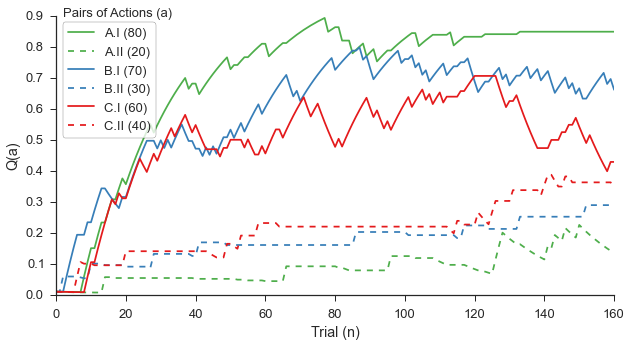

In [99]:
sns.set(font_scale=1.3, style='ticks')
f, ax = plt.subplots(1, figsize=(10,5))
plt.plot(qdict['a'], label='A.I (80)', color=flatui[2])
plt.plot(qdict['b'], label='A.II (20)', color=flatui[2], ls='--')

plt.plot(qdict['c'], label='B.I (70)', color=flatui[1])
plt.plot(qdict['d'], label='B.II (30)', color=flatui[1], ls='--')

plt.plot(qdict['e'], label='C.I (60)', color=flatui[0])
plt.plot(qdict['f'], label='C.II (40)', color=flatui[0], ls='--')
plt.legend(loc=2, fancybox=True, frameon=True, framealpha=.8)
plt.gca().text(2, .9, 'Pairs of Actions (a)', fontsize=13)
plt.gca().set_ylabel('Q(a)')
plt.gca().set_xlabel('Trial (n)')
sns.despine()
plt.savefig('probabilistic_qlearning_diexplorer.png', dpi=600)

In [18]:
def di_lca(Id=3, Ii=3, Ix=3, Io=2, Wd=.19, Wi=.19, Wx=.19, k=.84, si=2.3, dt=.01, tau=.05, tmax=5.5, rmax=100, b=50, g=20, ntrials=10, y=1, Z=10, IoMax=4.5):
    """
    tau:       time constant (cf NMDA receptors)
    k:         recurrent excitatory feedback
    w:         strength of cross-inhibition

    rmax:      max rate of cells
    ithresh:   input needed for 1/2-max firing
    idelta:    determines steepness of sigmoidal f-I curve
    """

    Tex = np.arange(0, tmax, dt)

    ntp=len(Tex)
    Rd = np.zeros((ntrials, ntp))#+Io
    Ri = np.zeros((ntrials, ntp))#+Io
    Rx = np.zeros((ntrials, ntp))#+Io


    for tn in xrange(ntrials):

        # generate independent noise for each pop.
        Ed = si*np.sqrt(dt/tau)*rs(ntp) 
        Ei = si*np.sqrt(dt/tau)*rs(ntp)
        Ex = si*np.sqrt(dt/tau)*rs(ntp)

        for i in np.arange(2,ntp):
            #Rd[tn,i]=Rd[tn,i-1]+dt/tau*(rmax/(1+np.exp(-(Io + Id+k*Rd[tn,i-1]+Wi*Ri[tn,i-1]+Wx*Rx[tn,i-1]-b)/g))-Rd[tn,i-1])+Ed[i]
            #Rx[tn,i]=Rx[tn,i-1]+dt/tau*(rmax/(1+np.exp(-(Io + Ix+k*Rx[tn,i-1]+Wi*Ri[tn,i-1]+Wd*Rd[tn,i-1]-b)/g))-Rx[tn,i-1])+Ex[i]
            #Ri[tn,i]=Ri[tn,i-1]+dt/tau*(rmax/(1+np.exp(-(Io + Ii+k*Ri[tn,i-1]+Wd*Rd[tn,i-1]+Wx*Rx[tn,i-1]-b)/g))-Ri[tn,i-1])+Ei[i]

            Rd[tn,i]=Rd[tn,i-1]+dt/tau*(rmax/(1+np.exp(-(Id+k*Rd[tn,i-1]+Wi*Ri[tn,i-1]-b)/g))-Rd[tn,i-1])+Ed[i]
            Ri[tn,i]=Ri[tn,i-1]+dt/tau*(rmax/(1+np.exp(-(Ii+k*Ri[tn,i-1]+Wd*Rd[tn,i-1]-b)/g))-Ri[tn,i-1])+Ei[i]

    return Rd, Ri

In [107]:
def simulate_learning(p, pc_map={'vd':['vd_e', 'vd_u', 'vd_l'], 'vi':['vi_e', 'vi_u', 'vi_l']}, nc=3, lr=array([.4,.3]), nssd=5, dt=.0005, si=.01, ntot=1000, tb=.68):

      dx=np.sqrt(si*dt)
      p = vectorize_params(p, pc_map=pc_map, ncond=nc)

      #Pd, Pi, Tex = update_execution(p)
      #t = np.cumsum([dt]*Tex.max())
      #xtb = temporal_dynamics(p, t)

      #Ph, Th = update_brake(p)
      #ss_index = [np.where(Th<Tex[c],Tex[c]-Th,0) for c in range(nc)]
      #return Pd, Pi
      rts, vd, vi, ex = [], [], [], []
      for i in xrange(ntot):

            Pex, Tex = update_execution(p)
            execution = np.cumsum(np.where((rs((nc, Tex.max())).T < Pex),dx,-dx).T)
            #indirect = np.where((rs((nc, Tex.max())).T < Pi),dx,-dx).T
            #execution = np.cumsum(direct+indirect, axis=1)

            r = np.argmax((execution.T>=p['a']).T, axis=1)*dt
            rt = p['tr']+(r*np.where(r==0, np.nan, 1))
            resp = np.where(rt<tb, 1, 0)
            
            # find conditions where response was recorded
            #for ci in np.where(~np.isnan(rt))[0]:
            p['vd']=p['vd'] + p['vd']*lr[0]
            p['vi']=p['vi'] - p['vi']*lr[1]


            vd.append(deepcopy(p['vd']))
            vi.append(deepcopy(p['vi']))
            rts.append(rt)
            ex.append(execution)

      vd = np.asarray(vd)
      vi = np.asarray(vi)
      rts = np.asarray(rts)
      ex = np.asarray(ex)
      return vd, vi, rts, ex

In [106]:
def analyze_execution(execution, p, trial_state):
      
      rt = p['tr'] + np.argmax((execution.T>=p['a']).T, axis=1)*dt
      rt[rt==p['tr'][0]]=999
      #rt[rt>0] = p['tr'][0]+rt[rt>0]
      #rt[rt==0] = 999
      #rt = p['tr']+(rx*np.where(rx==0, 999, 1))
      
      
      if np.all(rt==999):
            p['vd'] = p['vd']*1.02
            return [0,0], rt, 0, p
      
      r = np.where(rt==rt.min(), 1, 0)
      
      if trial_state=='l':
            if r[0]:
                  acc=1
                  p['vd'][0]=p['vd'][0]*1.02
                  p['vi'][0]=p['vi'][0]*.98
            elif r[1]:
                  acc=0
                  p['vi'][1]=p['vi'][1]*1.02
                  p['vd'][1]=p['vd'][1]*.98
      else:
            if r[0]:
                  acc=0
                  p['vi'][0]=p['vi'][0]*1.02
                  p['vd'][0]=p['vd'][0]*.98
            elif r[1]:
                  acc=1
                  p['vd'][1]=p['vd'][1]*1.02
                  p['vi'][1]=p['vi'][1]*.98
            
      #p['vd']=p['vd']+p['vd']*(acc*lr)
      #p['vi']=p['vi']+p['vi']*(err*lr)        
      
      #if np.any(rt[~np.isnan(rt)]<.4):
      #      print 'INSIDE'
      #      dirac = np.where(rts<.4, 1, 0)
      #      p['vd']=p['vd']-p['vd']*(dirac*lr)
      #      p['vi']=p['vd']+p['vi']*(dirac*lr)
      
      return r, rt, acc, p

NameError: name 'rt' is not defined

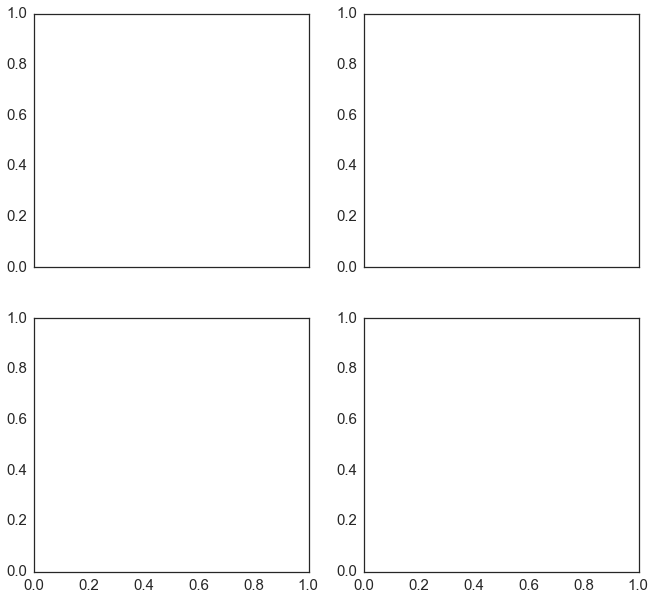

In [21]:
sns.set(style='white', font_scale=1.5)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, figsize=(12,10))

rd1, ri1, dv1 = decision_network(Id=4.4, Ii=2.15, Io=4., g=13, b=34, rmax=60, wid=.22, wdi=.22, si=2.2, k=.85, dt=.001)
rd2, ri2, dv2 = decision_network(Id=4.4, Ii=2.15, Io=2.5, g=13, b=34, rmax=60, wid=.22, wdi=.22, si=2.2, k=.85, dt=.001)

for data in [[rd1, ri1, dv1, 1], [rd2, ri2, dv2, .45]]:
      dual_space_plot(ax1, ax2, data[0], data[1], data[2], rts=rt, alpha=data[3])


#---------------------------------------------------------------------------------------      
      
      
rd3, ri3, dv3 = decision_network(Id=4.8, Ii=2., g=13, b=33, rmax=60, Io=0.5, wid=.22, wdi=.22, si=2.2, k=.86, dt=.001)
rd4, ri4, dv4 = decision_network(Id=4.4, Ii=2, g=13, b=33, rmax=60, Io=0.5, wid=.22, wdi=.22, si=2.2, k=.86, dt=.001)

      
for data in [[rd3, ri3, dv3, 1], [rd4, ri4, dv4, .45]]:
      dual_space_plot(ax3, ax4, data[0], data[1], data[2], alpha=data[3], rts=rt, title=False)